In [1]:
from pathlib import Path
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torch.nn as nn
import torch.optim as optim
import matplotlib.animation as animation
from IPython.display import HTML

def mnist_data_loader(batch_size=32):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_set = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_set = datasets.MNIST(root='./data', train=False, transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader

In [2]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [3]:
train_loader,test_loader = mnist_data_loader()

/Users/acaillon/miniforge3/envs/RAVE/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


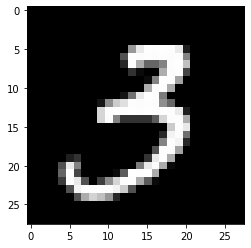

In [4]:
import matplotlib.pyplot as plt
import numpy as np
real_samples, real_labels = next(iter(train_loader))
plt.imshow(real_samples[0].reshape((28,28)), cmap="gray",)

In [5]:
# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 10

# Size of feature maps in generator
ngf = 8

# Size of feature maps in discriminator
ndf = 8

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

ngpu=1

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 4, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True), # inplace ReLU
            # current state size. (ngf*4) x 3
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 3, 2, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # current state size. (ngf*2) x 7
            nn.ConvTranspose2d( ngf * 2, ngf, 3, 2, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # current state size. ngf x 15
            nn.ConvTranspose2d( ngf, nc, 4, 2,2, bias=False),
            # current state size. nc x 28
            nn.Tanh() # Produce number between 0 and 1 for pixel values
        )

        #     # input is Z, going into a convolution
        #     nn.ConvTranspose2d( nz, ngf * 8, 4, 1, bias=False),
        #     nn.BatchNorm2d(ngf * 8),
        #     nn.ReLU(True),
        #     # state size. (ngf*8) x 4 x 4
        #     nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, bias=False),
        #     nn.BatchNorm2d(ngf * 4),
        #     nn.ReLU(True),
        #     # state size. (ngf*4) x 10 x 10
        #     nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, bias=False),
        #     nn.BatchNorm2d(ngf * 2),
        #     nn.ReLU(True),
        #     # state size. (ngf*2) x 22 x 22
        #     nn.ConvTranspose2d( ngf * 2, ngf, 4, 1, bias=False),
        #     nn.BatchNorm2d(ngf),
        #     nn.ReLU(True),
        #     # state size. (ngf) x 32 x 32
        #     nn.ConvTranspose2d( ngf, nc, 4, 1 ,bias=False),
        #     nn.Tanh()
        #     # state size. (nc) x 64 x 64
        # )


    def forward(self, input):
        return self.main(input)

In [8]:
netG=Generator(ngpu).to(device)


# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(10, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (10): Tanh()
  )
)


In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
        #     '''
        #     # input is (nc) x 28 x 28
        #     nn.Conv2d(nc, ndf, 4, 2, bias=False),
        #     # size : ndf x 13 x 13  
        #     nn.BatchNorm2d(ndf ),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Conv2d(ndf, ndf * 2, 2, 1, bias=False),
        #     #stat size 2.ndf x 12 x12
        #     nn.BatchNorm2d(ndf * 2),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Conv2d(2*ndf, ndf , 2, 1, bias=False),
        #     #stat size ndf x 11 x11
        #     nn.BatchNorm2d(ndf),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Conv2d(ndf, ndf//2 , 3, 2, bias=False),
        #     #stat size ndf//2 x 5 x 5 
        #     nn.BatchNorm2d(ndf //2 ),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Conv2d(ndf//2, ndf//4 , 3, 2, bias=False),
        #     #stat size ndf//4 x 2 x 2 
        #     nn.BatchNorm2d(ndf //4),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Conv2d(ndf//4, nc , 2, 1, bias=False),
        #     #stat size ndf//4 x 1 
        #     nn.BatchNorm2d(1),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     nn.Sigmoid()
        # )
        # '''
            # input is (nc) x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 6
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 3
            nn.Conv2d(ndf * 4, 1, 5, 1,1, bias=False),
            # state size. (ndf*4) x 1 x 1
            # nn.Sigmoid() # Produce probability
        )


    def forward(self, input):
        return self.main(input)

In [10]:
netD = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
  )
)


In [11]:
# Initialize BCELoss function
criterion = nn.HingeEmbeddingLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(56, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [12]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
k = 3
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader):

        # Antoine: Pas besoin de train le discriminateur plus souvent que le générateur

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size, ),
                           real_label,
                           dtype=torch.float,
                           device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)

        #print(output.shape,label.shape)
        # errD_real = criterion(output, label)
        # Antoine: attention hingeGAN c'est pas la même que hingeembedding
        # voir ici: https://paperswithcode.com/method/gan-hinge-loss
        errD_real = torch.relu(1 - output).mean()

        # Antoine: au lieu de backward real et fake séparément, mieux vaut additionner les deux loss

        D_x = output.mean().item()

        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = torch.relu(1 + output).mean()
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        errD.backward()

        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        # errG = criterion(output, label)
        errG = -output.mean()
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print(
                '[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, i, len(train_loader), errD.item(),
                   errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and
                                  (i == len(train_loader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/1875]	Loss_D: 2.0375	Loss_G: 0.1138	D(x): -0.0844	D(G(z)): -0.0469 / -0.1138
[0/5][50/1875]	Loss_D: 1.1520	Loss_G: 0.2720	D(x): 0.7687	D(G(z)): -0.1376 / -0.2720
[0/5][100/1875]	Loss_D: 0.1299	Loss_G: 1.1250	D(x): 1.1444	D(G(z)): -1.0709 / -1.1250
[0/5][150/1875]	Loss_D: 0.0320	Loss_G: 1.2934	D(x): 1.3791	D(G(z)): -1.2669 / -1.2934
[0/5][200/1875]	Loss_D: 0.0017	Loss_G: 1.4232	D(x): 1.6969	D(G(z)): -1.3443 / -1.4232
[0/5][250/1875]	Loss_D: 0.0016	Loss_G: 1.2499	D(x): 1.5175	D(G(z)): -1.2558 / -1.2499
[0/5][300/1875]	Loss_D: 0.0155	Loss_G: 1.4415	D(x): 1.5768	D(G(z)): -1.2042 / -1.4415
[0/5][350/1875]	Loss_D: 0.0114	Loss_G: 1.4866	D(x): 1.6648	D(G(z)): -1.3729 / -1.4866
[0/5][400/1875]	Loss_D: 0.0046	Loss_G: 1.8890	D(x): 1.7827	D(G(z)): -1.9505 / -1.8890
[0/5][450/1875]	Loss_D: 0.3271	Loss_G: 1.0591	D(x): 0.7329	D(G(z)): -2.0711 / -1.0591
[0/5][500/1875]	Loss_D: 0.0079	Loss_G: 1.3957	D(x): 1.6833	D(G(z)): -1.5368 / -1.3957
[0/5][550/1875]	Loss_D: 0.0697

KeyboardInterrupt: 

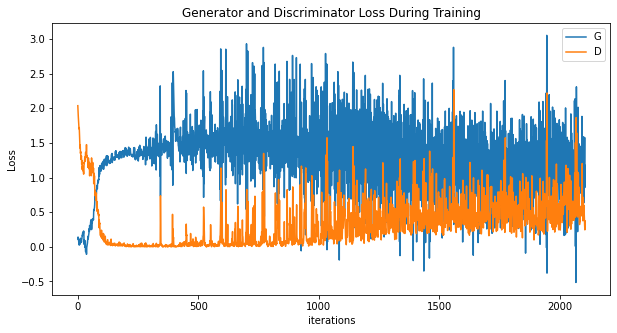

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

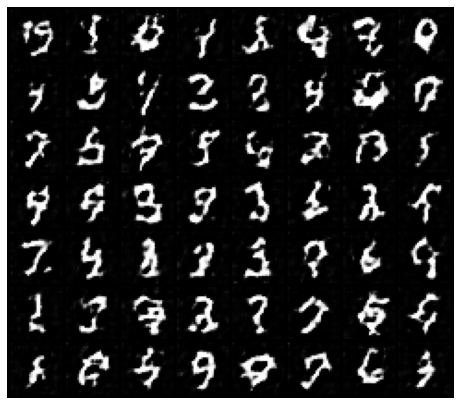

In [14]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())